In [1]:
!pip install -q siuba plotnine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.6 MB/s eta 0:00:00


In [12]:
#| echo: true
#| output: true

import numpy as np
import pandas as pd
#pd.set_option("display.max_rows", 10)
#from tabulate import tabulate
import siuba as si
import plotnine as p9
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# plotnine theme
some_theme = p9.theme_dark() + p9.theme(
    text=p9.element_text(face="bold", size=20),
    plot_background=p9.element_rect(fill='gray', colour='black')
)

# read csv
#df = pd.read_csv("~/dev/ccg-web/csv/scom-gpols.csv", sep="\t", header=0)
#df = pd.read_csv("scom-gpols.csv", sep="\t", header=0)
df = pd.read_csv("https://raw.githubusercontent.com/nils-holmberg/ccg-web/main/csv/scom-gpols.csv", sep="\t", header=0)

#list(df.columns)
df.head()

,image,id,text
0,aline_lessner-higher_education-4185-7,4185,Several Swedish universities place high in Eur...
1,aline_lessner-students-4782-7,4782,Several Swedish universities place high in Eur...
2,aline_lessner-students-4783-7,4783,Several Swedish universities place high in Eur...
3,anna_sigge-fashion_from_forests-6404-7,6404,Knitted dress made of 100 per cent paper from ...
4,ann-sofi_rosenkvist-children_on_bikes-4910-7,4910,Learning to ride a bike is something you&#039;...


In [3]:
import re
from pprint import pprint

In [4]:
# Run in python console
import nltk
nltk.download('stopwords')

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# spacy for lemmatization
import spacy
# Run in terminal or command prompt
!python3 -m spacy download en_core_web_sm
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm')#, disable=['parser', 'ner'])

In [6]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


In [7]:
df['text'] = df['text'].str.replace("&#039;", "'", regex=False)


In [9]:
# Function to split the 'text' column into sentences and add a column for sentence number
def sentences_split(row):
    doc = nlp(str(row['text']))
    sentences = []
    for i, sent in enumerate(doc.sents):
        sentences.append({'id': row['id'], 'sentence': sent.text, 'sentence_number': i + 1})
    return sentences
# Apply the function to the 'df' DataFrame and create a new DataFrame 'sent_df'
sentences_list = df.apply(sentences_split, axis=1).explode().tolist()
df_sent = pd.DataFrame(sentences_list)
df_sent.head()

,id,sentence,sentence_number
0,4185,Several Swedish universities place high in Eur...,1
1,4185,Many Master's programmes are taught in English...,2
2,4185,"More than 20,000 foreign students are studying...",3
3,4185,A good part of their social life revolves arou...,4
4,4185,The union can often help you with finding acco...,5


In [11]:
# Function to tokenize and analyze each sentence in 'df_sent' using spaCy
def tokens_split(row):
    doc = nlp(str(row['sentence']))
    tokens = []
    for i, token in enumerate(doc):
        entity = 'None' if token.ent_type_ == '' else token.ent_type_
        tokens.append({
            'id': row['id'],
            'sentence_number': row['sentence_number'],
            'token': token.text,
            'token_number': i + 1,
            'pos': token.pos_,
            'entity': entity,
            'lemma': token.lemma_
        })
    return tokens
# Apply the function to the 'sent_df' DataFrame and create a new DataFrame 'tokens_df'
tokens_list = df_sent.apply(tokens_split, axis=1).explode().tolist()
df_tokens = pd.DataFrame(tokens_list)
df_tokens.head()

,id,sentence_number,token,token_number,pos,entity,lemma
0,4185,1,Several,1,ADJ,None,several
1,4185,1,Swedish,2,ADJ,NORP,swedish
2,4185,1,universities,3,NOUN,None,university
3,4185,1,place,4,VERB,None,place
4,4185,1,high,5,ADJ,None,high


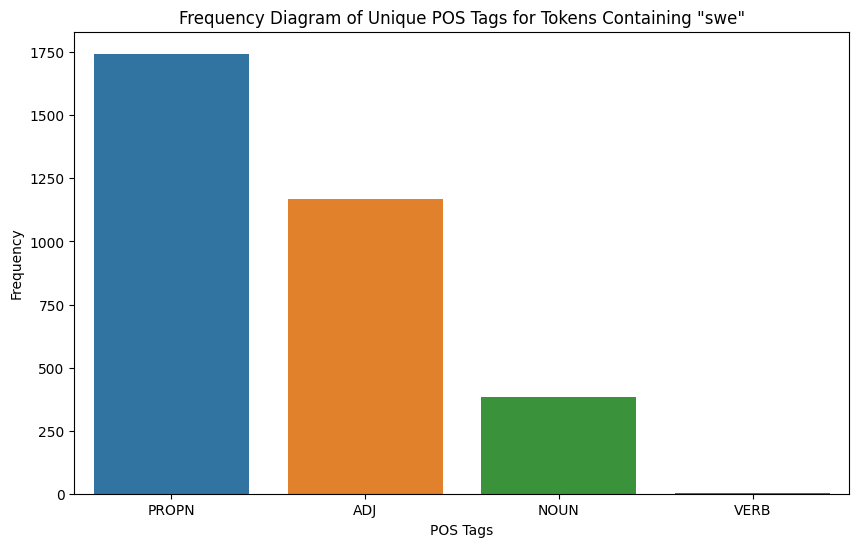

In [14]:
# Filter the DataFrame where the 'token' column contains the case-insensitive substring 'swe'
df_tokens_filtered = df_tokens[df_tokens['token'].str.contains('swe', case=False)]
# Plot the frequency diagram of unique POS tags in the 'pos_tag' column of the filtered DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(data=df_tokens_filtered, x='pos', order=df_tokens_filtered['pos'].value_counts().index)
plt.title('Frequency Diagram of Unique POS Tags for Tokens Containing "swe"')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Write the 'tokens_df_sent' DataFrame to a TSV file called 'scom-gpols-tokens.tsv'
df_tokens.to_csv('scom-gpols-tokens.tsv', sep='\t', index=False)

- link to dataset [scom-gpols-tokens.tsv](https://raw.githubusercontent.com/nils-holmberg/cca-nlp/main/csv/scom-gpols-tokens.tsv)

In [28]:
# Convert to list
data = df.text.values.tolist()


In [32]:
pprint(data[:2])

['Several Swedish universities place high in European rankings, and their '
 'research has contributed to the global success of Sweden’s many high-tech '
 'companies. Many Masters programmes are taught in English, and scholarships '
 'are available for international students. More than 20,000 foreign students '
 'are studying in Sweden, making for a vibrant, international study '
 'environment. A good part of their social life revolves around their student '
 'union. The union can often help you with finding accommodation and other '
 'practical matters. Relations between students and teachers are highly '
 'informal. Personal initiative and independent thinking are prized. Students '
 'are required to take an active role and contribute with opinions and ideas '
 'at lectures, seminars and in group discussions. Taking the initiative and '
 'questioning old presumptions is rewarding, especially in the long term. Many '
 'programmes also cooperate closely with industry.',
 'Several Swedi

In [41]:
from itertools import chain
# Create a new DataFrame to store the separated sentences and corresponding IDs
new_df = pd.DataFrame(columns=['id', 'sentence_number', 'sentence'])
# Iterate through each row in the original DataFrame
for index, row in df.iterrows():
    # Split the text into sentences
    sentences = str(row['text']).split('. ')
    # Create a list of sentence numbers
    sentence_numbers = list(range(1, len(sentences) + 1))
    # Create a list of IDs corresponding to each sentence
    ids = [row['id']] * len(sentences)
    # Create a temporary DataFrame
    temp_df = pd.DataFrame({'id': ids, 'sentence_number': sentence_numbers, 'sentence': sentences})
    # Append the temporary DataFrame to the new DataFrame
    new_df = pd.concat([new_df, temp_df], ignore_index=True)
# Display the new DataFrame
new_df.head()

,id,sentence_number,sentence
0,4185,1,Several Swedish universities place high in Eur...
1,4185,2,Many Master&#039;s programmes are taught in En...
2,4185,3,"More than 20,000 foreign students are studying..."
3,4185,4,A good part of their social life revolves arou...
4,4185,5,The union can often help you with finding acco...


In [ ]:
#| include: false
#| echo: true
#| output: true

if False:
    # Generate a frequency diagram of the variable 'Könstillhörighet'
    df_freq = si.count(df, si._.Könstillhörighet) >> si.arrange(-si._.n)

    # Plotting the frequency diagram using plotnine
    plot = (p9.ggplot(df_freq, p9.aes(x='Könstillhörighet', y='n')) +
            p9.geom_bar(stat='identity') +
            #p9.theme_minimal() +
            p9.ggtitle('Frequency Diagram of Könstillhörighet') +
            some_theme)
    #
    plot

In [ ]:
#| include: false
#| echo: true
#| output: true

if False:
    # Save the plotnine plot as a PNG image
    plot.save('../fig/genai-p9.png', width=10, height=8, dpi=300)

## matplotlib

In [ ]:
#| include: false
#| echo: true
#| output: true

if False:
    fig = plot.draw()
    #
    fig

In [ ]:
#| include: false
#| echo: true
#| output: true

if False:
    # Save the matplotlib figure as a PNG image
    fig.savefig('../fig/genai-plt.png', format='png', dpi=300)